In [ ]:
from torch import nn
import torch
from torch.utils.data import TensorDataset
from AbstractModel import AbstractModel
import onnx
import numpy as np
import pandas as pd
from onnx import numpy_helper
from collections import OrderedDict

In [ ]:
def paths(name):    
#     sit_code = '0375'
    model_path = f'M:/jupyter_notebooks/onnx_notebooks/{name}.onnx'
    quantized_path = 'M:/jupyter_notebooks/onnx_notebooks/'

    path = f'M:/jupyter_notebooks/onnx_notebooks/'
#     data_path = 'M:/quantization/data_onnx/'
#     csv_name = f'action-{sit_code}-holdout.csv'
    return model_path, quantized_path, path

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType
def quantization(quantized_path, model_path):
    name = quantized_path
    for subname in model_path.split('/')[-1:]:
        subname = subname.split('.')
        name += subname[0]+'_quant.'+subname[1]+'/' 
    model_quant_path = name[:-1]
    quantized_model = quantize_dynamic(model_path, model_quant_path, weight_type=QuantType.QUInt8,nodes_to_quantize=['Gemm_0','Gemm_2','Gemm_4','Relu_1','Relu_3','Relu_5'])
    return quantized_model, model_quant_path

In [ ]:
import os
def calc_size(model_path, model_quant_path):
#     torch.save(model.state_dict(), "/tmp/model.p")
    size_mod = os.path.getsize(model_path)
    size_quant = os.path.getsize(model_quant_path)
#     os.remove('/tmp/model.p')
    print("{:.3f} KB".format(size_mod / 1024), "{:.3f} KB".format(size_quant / 1024))

In [ ]:
import onnxruntime as rt
def inference(model_path, model_quant):
    sess = rt.InferenceSession(model_path)
    sess2 = rt.InferenceSession(model_quant)
    input_name = sess.get_inputs()[0].name
    label_name = sess.get_outputs()[0].name
    return sess, sess2, input_name, label_name

In [ ]:
import time
def times(sess, sess2, input_name, label_name, inp_dim):
    times_ = []
    datas = []
    repeat_vec = 1000
    for i in range(10):
        data=np.random.rand(1, inp_dim).astype(np.float32)
        time1 = time.time()
        for k in range(repeat_vec):
            result = sess.run([label_name], {input_name: data})
        time2 = time.time()
        orig = (time2-time1)/repeat_vec
        time1 = time.time()
        for k in range(repeat_vec):
            result = sess2.run([label_name], {input_name: data})
        time2 = time.time()
        quant = (time2-time1)/repeat_vec
        times_.append(orig/quant)
        print(orig/quant)
        datas.append(data)
    print('В среднем прирост на 10-ти разных векторах:', np.array(times_).mean())
    return times_, datas

In [ ]:
class MyModel(AbstractModel):
    def __init__(self, n_in_features, n_out_features=4, neurons=300, depth=1):
        super().__init__()
        layers = []
        for i in range(depth+1):
            if i == 0:
                layers.append((f'conv{i+1}', nn.Linear(n_in_features, neurons)))
            else: 
                layers.append((f'conv{i+1}', nn.Linear(neurons, neurons)))
                
            layers.append((f'relu{i+1}', nn.ReLU()))
            if i == depth:
                layers.append((f'conv{i+2}', nn.Linear(neurons, n_out_features)))
        if n_out_features != 1:
            layers.append(((f'softmax', nn.Softmax(-1))))
        else: layers.append(((f'sigmoid', nn.Sigmoid())))
            
            
        self.model = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.model(x)

In [ ]:
neurons = 300
overall_times = []
for i in np.arange(4):
    
    student = MyModel(64, 4, neurons, depth = i)
    x = torch.tensor(np.random.rand(4000, 64))
    torch.onnx.export(student, x.float()[0].reshape(1,-1), "student_kd.onnx", verbose=True,opset_version=13)#, input_names=input_names, output_names=output_names)
    
    file = 'student_kd'
    model_path, quantized_path, path = paths(file)
    quantized_model, quantized_model_path = quantization(quantized_path, model_path)
    calc_size(model_path, quantized_model_path)
    sess, sess2, input_name, label_name, = inference(model_path, quantized_model_path)
    input_dim = 64
    times_, datas = times(sess, sess2, input_name, label_name, input_dim)
    overall_times.append(times_)

In [ ]:
different_depths = np.arange(5)
different_vectors = 10
# np.array(list(different_depths)*different_vectors).reshape(different_vectors,-1).T.reshape(1,-1)

In [ ]:
y = np.array(overall_times).reshape(1,-1) 
x = np.array(list(different_depths)*different_vectors).reshape(different_vectors,-1).T.reshape(1,-1)
df_depth_dynamic = pd.DataFrame(np.concatenate((x,y)).T)

In [ ]:
#10 векторов, 1к каждый
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
plt.figure(figsize=(15,8))
sns.boxplot(x=df_depth_dynamic[0].astype(int)+1, y=df_depth_dynamic[1])
plt.xlabel('num of layers')
plt.ylabel('growth, %')
plt.title('dependency of quantized nets\' perfomance growth on number of layers')

In [ ]:
# neurons = 300
overall_times_depths = []
for i in np.arange(300,310,10):
    
    student = MyModel(64, 4, i, depth = 1)
    x = torch.tensor(np.random.rand(4000, 64))
    torch.onnx.export(student, x.float()[0].reshape(1,-1), "student_kd.onnx", verbose=True)#, input_names=input_names, output_names=output_names)
    
    file = 'student_kd'
    model_path, quantized_path, path = paths(file)
    quantized_model, quantized_model_path = quantization(quantized_path, model_path)
    calc_size(model_path, quantized_model_path)
    sess, sess2, input_name, label_name, = inference(model_path, quantized_model_path)
    input_dim = 64
    times_, datas = times(sess, sess2, input_name, label_name, input_dim)
    overall_times_depths.append(times_)

graph(%input.1 : Float(1, 64, strides=[64, 1], requires_grad=0, device=cpu),
      %model.conv1.weight : Float(300, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %model.conv1.bias : Float(300, strides=[1], requires_grad=1, device=cpu),
      %model.relu1.weight : Float(1, strides=[1], requires_grad=1, device=cpu),
      %model.conv2.weight : Float(300, 300, strides=[300, 1], requires_grad=1, device=cpu),
      %model.conv2.bias : Float(300, strides=[1], requires_grad=1, device=cpu),
      %model.relu2.weight : Float(1, strides=[1], requires_grad=1, device=cpu),
      %model.conv3.weight : Float(4, 300, strides=[300, 1], requires_grad=1, device=cpu),
      %model.conv3.bias : Float(4, strides=[1], requires_grad=1, device=cpu)):
  %9 : Float(1, 300, strides=[300, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%input.1, %model.conv1.weight, %model.conv1.bias) # m:\python\lib\site-packages\torch\nn\functional.py:1848:0
  %10 : Float(1, 300, strides=[3

In [ ]:
different_depths = np.arange(10,1500,100)
different_vectors = 10
overall_times_depths

In [ ]:
y = np.array(overall_times_depths).reshape(1,-1) 
x = np.array(list(different_depths)*different_vectors).reshape(different_vectors,-1).T.reshape(1,-1)
df_width_dynamic = pd.DataFrame(np.concatenate((x,y)).T)

Text(0.5, 1.0, "dependency of quantized nets' perfomance growth on width of layers")

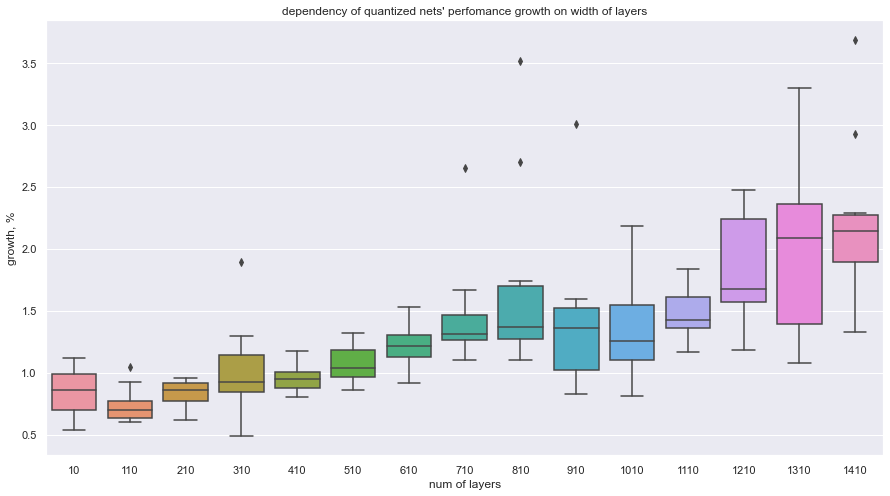

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
plt.figure(figsize=(15,8))
sns.boxplot(x=df_width_dynamic[0].astype(int), y=df_width_dynamic[1])
plt.xlabel('num of layers')
plt.ylabel('growth, %')
plt.title('dependency of quantized nets\' perfomance growth on width of layers')

In [ ]:
def paths(name):    
#     sit_code = '0375'
    model_path = f'M:/jupyter_notebooks/onnx_notebooks/{name}.onnx'
    quantized_path = 'M:/jupyter_notebooks/onnx_notebooks/'

    path = f'M:/jupyter_notebooks/onnx_notebooks/'
#     data_path = 'M:/quantization/data_onnx/'
#     csv_name = f'action-{sit_code}-holdout.csv'
    return model_path, quantized_path, path

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType
def get_model_quant_path(quantized_path):  
    name = quantized_path
    for subname in model_path.split('/')[-1:]:
        subname = subname.split('.')
        name += subname[0]+'_quant.'+subname[1]+'/' 
    model_quant_path = name[:-1]
    return model_quant_path

In [ ]:
import os
def calc_size(model_path, model_quant_path):
#     torch.save(model.state_dict(), "/tmp/model.p")
    size_mod = os.path.getsize(model_path)
    size_quant = os.path.getsize(model_quant_path)
#     os.remove('/tmp/model.p')
    print("{:.3f} KB".format(size_mod / 1024), "{:.3f} KB".format(size_quant / 1024))

In [ ]:
import onnxruntime as rt
def inference(model_path, model_quant):
    sess = rt.InferenceSession(model_path)
    sess2 = rt.InferenceSession(model_quant)
    input_name = sess.get_inputs()[0].name
    label_name = sess.get_outputs()[0].name
    return sess, sess2, input_name, label_name

In [ ]:
import time
def times(sess, sess2, input_name, label_name, inp_dim):
    times_ = []
    datas = []
    repeat_vec = 10000
    for i in range(10):
        data=np.random.rand(1, inp_dim).astype(np.float32)
        for k in range(1000):
            result = sess.run([label_name], {input_name: data})

        time1 = time.time()
        for k in range(repeat_vec):
            result = sess.run([label_name], {input_name: data})
        time2 = time.time()
        orig = (time2-time1)/repeat_vec
        for k in range(1000):
            result = sess2.run([label_name], {input_name: data})

        time1 = time.time()
        for k in range(repeat_vec):
            result = sess2.run([label_name], {input_name: data})
        time2 = time.time()
        quant = (time2-time1)/repeat_vec
        times_.append(orig/quant)
        print(orig/quant)
        datas.append(data)
    print('В среднем прирост на 10-ти разных векторах:', np.array(times_).mean())
    return times_, datas

In [ ]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType
class DataReader(CalibrationDataReader):
    def __init__(self, calibration_numpy):
        self.data = calibration_numpy
        self.enum_data_dicts = iter([{input_name: nhwc_data.reshape(1, -1).astype(np.float32)} for nhwc_data in self.data])
        self.datasize = 0

    def get_next(self):
        self.datasize = self.data.shape[0]
        return next(self.enum_data_dicts, None)

In [ ]:
def static_quantization(model_path,
                    quantized_model_path,
                    dr):

    quantized_model = quantize_static(model_path,
                    quantized_model_path,
                    dr)

    print('ONNX full precision model size (KB):', os.path.getsize(model_path)/(1024))
    print('ONNX quantized model size (KB):', os.path.getsize(quantized_model_path)/(1024))

In [ ]:
class MyModel(AbstractModel):
    def __init__(self, n_in_features, n_out_features=4, neurons=300, depth=1):
        super().__init__()
        layers = []
        for i in range(depth+1):
            if i == 0:
                layers.append((f'conv{i+1}', nn.Linear(n_in_features, neurons)))
            else: 
                layers.append((f'conv{i+1}', nn.Linear(neurons, neurons)))
                
            layers.append((f'relu{i+1}', nn.ReLU()))
            if i == depth:
                layers.append((f'conv{i+2}', nn.Linear(neurons, n_out_features)))
        if n_out_features != 1:
            layers.append(((f'softmax', nn.Softmax(-1))))
        else: layers.append(((f'sigmoid', nn.Sigmoid())))
            
            
        self.model = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.model(x)

In [ ]:
# n_in_features = 64
# neurons = 300
# n_out_features = 1
# layers = []
# depth = 1
# for i in range(depth+1):
#     if i == 0:
#         layers.append((f'conv{i+1}', nn.Linear(n_in_features, neurons)))
#     else: 
#         layers.append((f'conv{i+1}', nn.Linear(neurons, neurons)))
        
#     layers.append((f'relu{i+1}', nn.PReLU()))
#     if i == depth:
#         layers.append((f'conv{i+2}', nn.Linear(neurons, n_out_features)))
# if n_out_features != 1:
#     layers.append(((f'softmax', nn.Softmax(-1))))
# else: layers.append(((f'sigmoid', nn.Sigmoid())))
# nn.Sequential(OrderedDict(layers))

In [ ]:
# input_name = ''
# student = MyModel(64, 4, neurons, depth = i)
# x = torch.tensor(np.random.rand(4000, 64))
# torch.onnx.export(student, x.float()[0].reshape(1,-1), "student_kd.onnx", verbose=True)#, input_names=input_names, output_names=output_names)
    
# file = 'student_kd'
# model_path, quantized_path, path = paths(file)
# quantized_model_path = get_model_quant_path(quantized_path)

# input_name = rt.InferenceSession(model_path).get_inputs()[0].name

In [ ]:
# x = torch.tensor(np.random.rand(4000, 64))
# x.float()[0].reshape(1,-1).shape, x.shape

In [ ]:
vec = np.random.rand(100,64)
neurons = 300
overall_times = []
for i in np.arange(5):
    
    student = MyModel(64, 4, neurons, depth = i)
    x = torch.tensor(np.random.rand(1, 64))
    torch.onnx.export(student, x.float().reshape(1,-1), "student_kd.onnx", verbose=True, opset_version=13)#, input_names=input_names, output_names=output_names)
    
    file = 'student_kd'
    model_path, quantized_path, path = paths(file)
    quantized_model_path = get_model_quant_path(quantized_path)
    
    input_name = 'input.1'
    dr = DataReader(vec)

    static_quantization(model_path,
                    quantized_model_path, dr)
    
    sess, sess2, input_name, label_name, = inference(model_path, quantized_model_path)
    
    times_, datas = times(sess, sess2, input_name, label_name, 64)
    overall_times.append(times_)

In [ ]:
different_depths = np.arange(5)
different_vectors = 10

In [ ]:
y = np.array(overall_times).reshape(1,-1) 
x = np.array(list(different_depths)*different_vectors).reshape(different_vectors,-1).T.reshape(1,-1)
df_depth_static = pd.DataFrame(np.concatenate((x,y)).T)

Text(0.5, 1.0, "dependency of quantized nets' perfomance growth on number of layers")

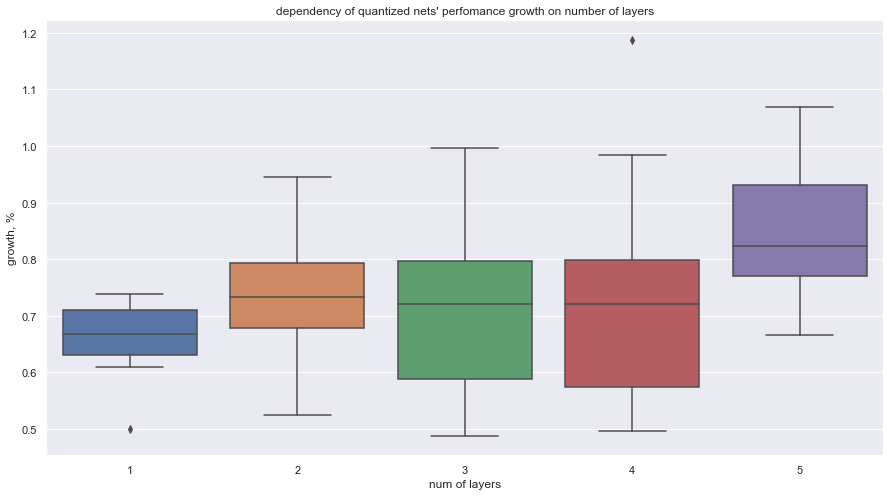

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
plt.figure(figsize=(15,8))
sns.boxplot(x=df_depth_static[0].astype(int)+1, y=df_depth_static[1])
plt.xlabel('num of layers')
plt.ylabel('growth, %')
plt.title('dependency of quantized nets\' perfomance growth on number of layers')

In [ ]:
vec = np.random.rand(100,64)
neurons = 300
overall_times = []
for i in np.arange(10,1500,100):
    
    student = MyModel(64, 4, i, depth = 3)
    x = torch.tensor(np.random.rand(1, 64))
    torch.onnx.export(student, x.float().reshape(1,-1), "student_kd.onnx", verbose=True, opset_version=13)#, input_names=input_names, output_names=output_names)
    
    file = 'student_kd'
    model_path, quantized_path, path = paths(file)
    quantized_model_path = get_model_quant_path(quantized_path)
    
    input_name = 'input.1'
    dr = DataReader(vec)

    static_quantization(model_path,
                    quantized_model_path, dr)
    
    sess, sess2, input_name, label_name, = inference(model_path, quantized_model_path)
    
    times_, datas = times(sess, sess2, input_name, label_name, 64)
    overall_times.append(times_)

In [ ]:
different_depths = np.arange(10,1500,100)
different_vectors = 10
overall_times

In [ ]:
y = np.array(overall_times).reshape(1,-1) 
x = np.array(list(different_depths)*different_vectors).reshape(different_vectors,-1).T.reshape(1,-1)
df_width_static = pd.DataFrame(np.concatenate((x,y)).T)

Text(0.5, 1.0, "dependency of quantized nets' perfomance growth on number of layers")

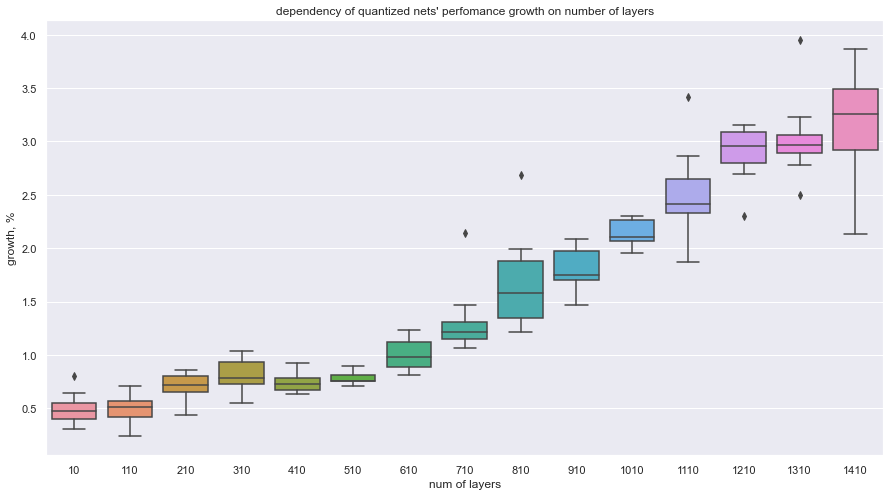

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
plt.figure(figsize=(15,8))
sns.boxplot(x=df_width_static[0].astype(int), y=df_width_static[1])
plt.xlabel('num of layers')
plt.ylabel('growth, %')
plt.title('dependency of quantized nets\' perfomance growth on number of layers')

In [ ]:
df = pd.DataFrame(np.concatenate((df_width_static, df_width_dynamic), axis=0))
df['тип квантизации'] = ['статическая']*df_width_static.shape[0]+['динамическая']*df_width_static.shape[0]

Text(0.5, 1.0, 'Зависимость прироста скорости квантованной сетки от ширина слоев нейросети')

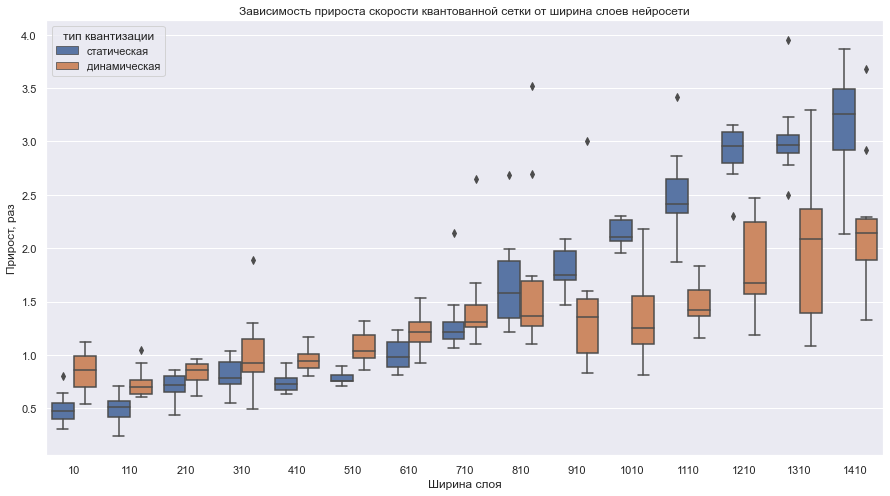

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
plt.figure(figsize=(15,8))
sns.boxplot(x=df[0].astype(int), y=df[1], hue = 'тип квантизации', data= df)

plt.xlabel('Ширина слоя')
plt.ylabel('Прирост, раз')
plt.title('Зависимость прироста скорости квантованной сетки от ширина слоев нейросети')

In [ ]:
# df = np.concatenate((df_depth_static[1], df_depth_dynamic[1]), axis=0).reshape(-1, len(df_depth_static[1]))
df = pd.DataFrame(np.concatenate((df_depth_static, df_depth_dynamic), axis=0))
df['тип квантизации'] = ['статическая']*df_depth_static.shape[0]+['динамическая']*df_depth_static.shape[0]

Text(0.5, 1.0, 'Зависимость прироста скорости квантованной сетки от глубины нейросети')

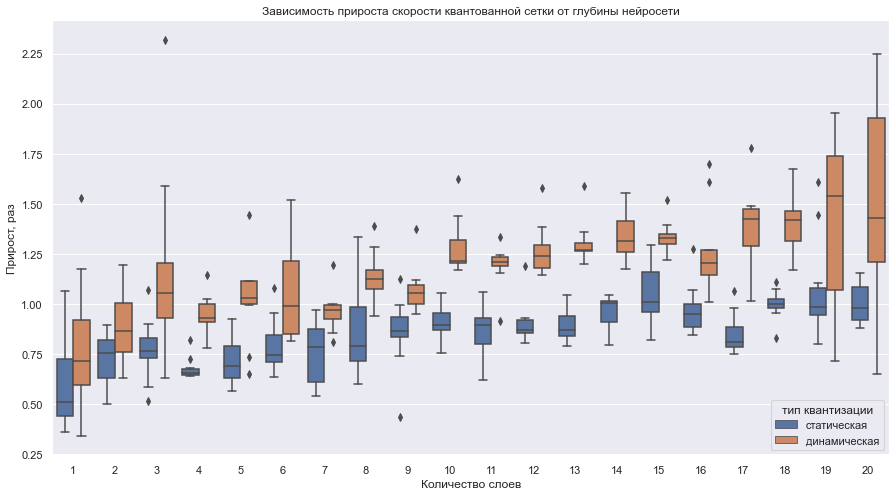

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
plt.figure(figsize=(15,8))
sns.boxplot(x=df[0].astype(int)+1, y=df[1], hue = 'тип квантизации', data= df)

plt.xlabel('Количество слоев')
plt.ylabel('Прирост, раз')
plt.title('Зависимость прироста скорости квантованной сетки от глубины нейросети')

In [ ]:
df[:200]

,0,1,тип квантизации
0,0.0,0.362004,статическая
1,0.0,1.065474,статическая
2,0.0,0.760967,статическая
3,0.0,0.439143,статическая
4,0.0,0.801642,статическая
...,...,...,...
195,19.0,0.907229,статическая
196,19.0,1.132300,статическая
197,19.0,1.154415,статическая
198,19.0,0.878364,статическая


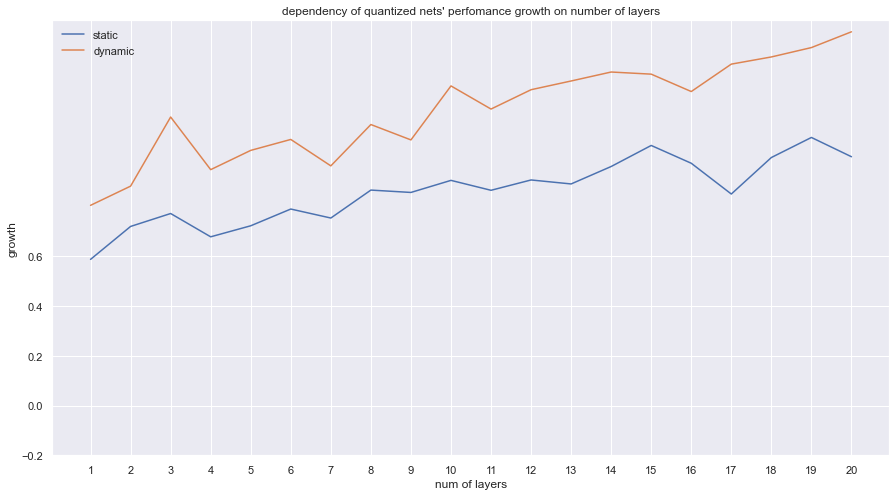

In [ ]:
plt.plot(np.arange(20).astype(int)+1, df[:200].groupby(0).mean())
plt.plot(np.arange(20).astype(int)+1, df[200:].groupby(0).mean())
plt.title('dependency of quantized nets\' perfomance growth on number of layers')

plt.xlabel('num of layers')
plt.ylabel('growth')
a = plt.xticks(np.arange(1,21).astype(int), np.arange(1,21).astype(int))
a = plt.yticks(np.arange(-0.2,0.7,0.2))
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.style.use('seaborn-darkgrid')
plt.legend(['static', 'dynamic'])

In [ ]:
df = pd.DataFrame(np.concatenate((df_width_static, df_width_dynamic), axis=0))
df['type_of_quantization'] = ['static']*df_width_static.shape[0]+['dynamic']*df_width_static.shape[0]

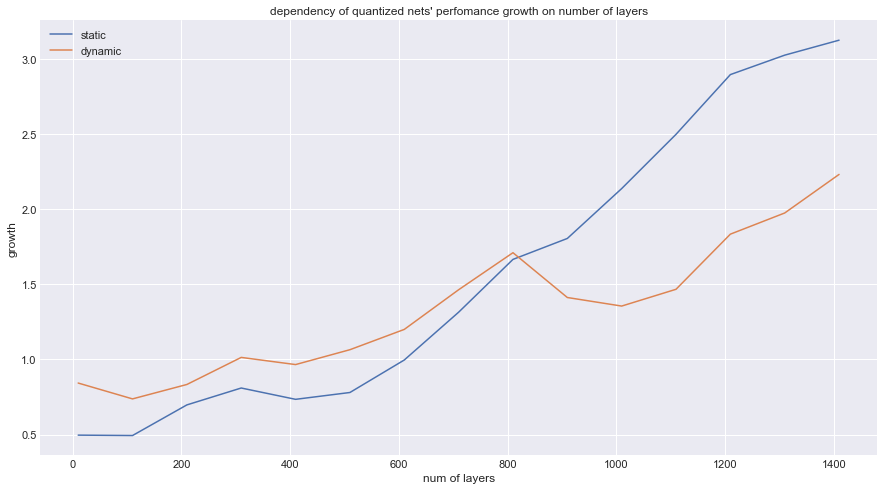

In [ ]:
plt.plot(df[:150].groupby(0).mean().index, df[:150].groupby(0).mean())
plt.plot(df[:150].groupby(0).mean().index, df[150:].groupby(0).mean())
plt.title('dependency of quantized nets\' perfomance growth on number of layers')

plt.xlabel('num of layers')
plt.ylabel('growth')
# a = plt.xticks(np.arange(1,21).astype(int), np.arange(1,21).astype(int))
# a = plt.yticks(np.arange(-0.2,0.7,0.2))
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.style.use('seaborn-darkgrid')
plt.legend(['static','dynamic'])